In [1]:
import pandas as pd
import numpy as np
#import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

sns.set_style("whitegrid")

In [2]:
#data set from kaggle: https://www.kaggle.com/competitions/grupo-bimbo-inventory-demand/data

#office
train = pd.read_csv("train.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'Demanda_uni_equil'])
test = pd.read_csv("test.csv", usecols=['Semana', 'Producto_ID', 'Cliente_ID', 'id'])

train = train.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})

test = test.rename(columns={'Semana': 'Week_num',
                                  'Agencia_ID': 'Sales_Depot_ID',
                                  'Canal_ID': 'Sales_Channel_ID',
                                  'Ruta_SAK': 'Route_ID',
                                  'Cliente_ID': 'Client_ID',
                                  'Venta_uni_hoy': 'Sales_unit_this_week',
                                  'Venta_hoy': 'Sales_this_week',
                                  'Dev_uni_proxima': 'Returns_unit_next_week',
                                  'Dev_proxima': 'Returns_next_week',
                                  'Demanda_uni_equil': 'adjusted_demand',
                                  'Producto_ID': 'Product_ID'})



#set a unique id for each client, product combination (thanks Gemini)
combined_df = pd.concat([train,test])
combined_df['ID'] = combined_df.groupby(['Client_ID', 'Product_ID']).ngroup()

train = combined_df.iloc[:len(train)].copy()
test = combined_df.iloc[len(train):].copy()

del combined_df


train = train.drop(columns='id')
train['adjusted_demand'] = train['adjusted_demand'].astype(int)
train = train.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

test = test.drop(columns='adjusted_demand')
test['id'] = test['id'].astype(int)
test = test.sort_values(by=['ID', 'Week_num']).reset_index(drop=True)

In [3]:
#create a dataframe of aggregate statistics for each client
testagg = train.groupby('Client_ID').agg({'Product_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

client_stats = pd.DataFrame()

client_stats['Client_ID'] = train['Client_ID'].unique()
client_stats['Products'] = testagg['Product_ID']['nunique']
client_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
client_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
client_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
client_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
client_stats['adj_dem_max'] = testagg['adjusted_demand']['max']



#create a dataframe of aggregate statistics for each product
del testagg
testagg = train.sort_values(by=['Product_ID']).groupby('Product_ID').agg({'Client_ID':'nunique', 'adjusted_demand':['mean', 'median', 'std', 'min', 'max']})
testagg = testagg.reset_index()

product_stats = pd.DataFrame()

product_stats['Product_ID'] = train.sort_values(by=['Product_ID'])['Product_ID'].unique()
product_stats['Clients'] = testagg['Client_ID']['nunique']
product_stats['adj_dem_mean'] = testagg['adjusted_demand']['mean'].round(2)
product_stats['adj_dem_median'] = testagg['adjusted_demand']['median'].astype(int)
product_stats['adj_dem_std'] = testagg['adjusted_demand']['std'].round(2)
product_stats['adj_dem_min'] = testagg['adjusted_demand']['min']
product_stats['adj_dem_max'] = testagg['adjusted_demand']['max']

del testagg

client_stats.head()

,Client_ID,Products,adj_dem_mean,adj_dem_median,adj_dem_std,adj_dem_min,adj_dem_max
0,26,51,28.10,20,26.62,0,132
1,60,34,188.83,130,228.27,11,2304
2,65,112,109.10,60,140.54,0,1669
3,101,4,81.60,28,86.40,20,280
4,105,72,50.36,26,57.83,2,459


In [26]:
print(client_stats['adj_dem_mean'].quantile(0.99))

print(client_stats['adj_dem_mean'].median())

40.0
4.22


In [16]:
print(len(client_stats))

print(len(client_stats[client_stats['adj_dem_mean'] <= 4]))

print(len(client_stats[(client_stats['adj_dem_mean'] > 4) & (client_stats['adj_dem_mean'] < 14)]))

880604
406493
433966


In [41]:
unique_ids = train['ID'].unique()

# Define the fraction of IDs to sample
fraction = 0.01  # sample 1% of the IDs

# Calculate the number of IDs to sample
sample_size = int(len(unique_ids) * fraction)

# Choose a random sample of IDs
sampled_ids = np.random.choice(unique_ids, size=sample_size, replace=False)

# Filter the DataFrame to keep all rows with the sampled IDs
train_tt = train[train['ID'].isin(sampled_ids)]

print(len(train_tt))

739783


The following function fills in missing weeks by taking the average of the surrounding weeks.

In [42]:
def fillin(df):
    '''
    Input
        df: A dataframe of length at most 7, with column names 'Week_num', 'Client_ID', 'Product_ID', 'adjusted_demand', 'ID',
        where 'ID' is the unique idenifier for client id and product id combinations.  The intended input is train[train['ID' == id]],
        where id is an element of the list train['ID'].unique().tolist().

    Outputs
        new_df: If df has 'adjusted_demand' values for each week (3 through 9), new_df = df, i.e. nothing happens.

                If df has missing 'adjusted_demand' values for any week, the 'adjusted_demand' for that week will
                be the average of the 'adjusted_demand' for the week prior and week after, starting with week 3.
                If the 'adjusted_demand' for the week prior or week after is also missing, it is assumed to be zero
                in order to perform the average calculation above.

    '''

    # EB: I'm not sure if it matters, but does it need to be a deep copy?
    new_df = df.copy(deep=True).reset_index(drop=True)

    week_list = new_df['Week_num'].unique().tolist()
    missing_week_list = [x for x in [3,4,5,6,7,8,9] if x not in week_list]

    for i in missing_week_list:

        #get previous weeks value
        if i-1 in week_list:
            prev_value = new_df[new_df['Week_num'] == i-1]['adjusted_demand'].iloc[0]
        else:
            prev_value = 0
        
        #get next weeks value
        if i+1 in week_list:
            next_value = new_df[new_df['Week_num'] == i+1]['adjusted_demand'].iloc[0]
        else:
            next_value = 0
        
        #create new row in new_df with the floor of the average value of prev_value and next_value
        new_df = pd.concat([new_df, pd.DataFrame({'Week_num': i,
                                                  'Client_ID': new_df['Client_ID'].iloc[0],
                                                  'Product_ID': new_df['Product_ID'].iloc[0],
                                                  'adjusted_demand': np.floor(0.5*(prev_value+next_value)).astype(int),
                                                  'ID': new_df['ID'].iloc[0]}, index=[i])]).sort_values(by=['Week_num']).reset_index(drop=True)
        
        #update week_list
        week_list.append(i)
        
    return new_df

In [43]:
train_tt.head()

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
88,5,26,34802,24,21
89,6,26,34802,25,21
90,7,26,34802,14,21
91,8,26,34802,9,21
186,4,26,43344,0,44


In [46]:
uid = train_tt['ID'].unique().tolist()
dfs = []

for j in range(len(uid)):
    dfs.append(fillin(train_tt[train_tt['ID'] == uid[j]]))

train_impute = pd.concat(dfs).reset_index(drop=True)

In [48]:
train_impute.head(21)

,Week_num,Client_ID,Product_ID,adjusted_demand,ID
0,3,26,34802,0,21
1,4,26,34802,12,21
2,5,26,34802,24,21
3,6,26,34802,25,21
4,7,26,34802,14,21
5,8,26,34802,9,21
6,9,26,34802,4,21
7,3,26,43344,0,44
8,4,26,43344,0,44
9,5,26,43344,0,44


In [49]:
ad1_list = np.zeros(len(train_impute))
ad_list = train_impute['adjusted_demand'].tolist()

for i in range(len(train_impute)):
    if i%7 == 0:
        ad1_list[i] = np.nan
    
    else:
        ad1_list[i] = ad_list[i-1]

train_impute['adj_demand_1'] = ad1_list

In [28]:
train_impute.to_csv('train_impute.csv', index=False)

NameError: name 'train_impute' is not defined

In [29]:
train_impute = pd.read_csv("train_impute.csv")

In [31]:
train_impute.head(21)

,Week_num,Client_ID,Product_ID,adjusted_demand,ID,adj_demand_1
0,3,26,34802,0,21,NaN
1,4,26,34802,12,21,0.0
2,5,26,34802,24,21,12.0
3,6,26,34802,25,21,24.0
4,7,26,34802,14,21,25.0
5,8,26,34802,9,21,14.0
6,9,26,34802,4,21,9.0
7,3,26,43344,0,44,NaN
8,4,26,43344,0,44,0.0
9,5,26,43344,0,44,0.0


In [27]:
train_impute = train_impute.dropna(subset=['adj_demand_1', 'adjusted_demand'])

train_impute.head()

NameError: name 'train_impute' is not defined

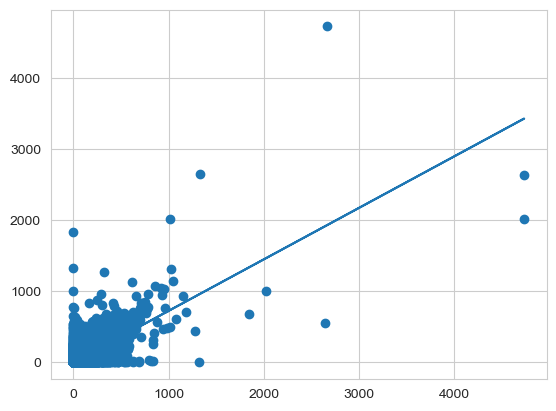

In [56]:
m, b = np.polyfit(train_impute['adj_demand_1'], train_impute['adjusted_demand'],1)

plt.scatter(train_impute['adj_demand_1'],train_impute['adjusted_demand'])

plt.plot(train_impute['adj_demand_1'], m*train_impute['adj_demand_1']+b)

plt.show()

In [58]:
df = pd.DataFrame({'id': np.arange(len(test)),
                   'Demanda_uni_equil': 7*np.ones(len(test)).astype(int)})

df_simple = pd.read_csv('simple_prediction.csv')

In [60]:
df_simple.head()

,id,Demanda_uni_equil
0,0,4
1,1,7
2,2,2
3,3,7
4,4,7


In [63]:
test = test.sort_values(by='id')

test.head()

,Week_num,Client_ID,Product_ID,id,ID
6574113,11,4639078,35305,0,25442195
6701119,11,4705135,1238,1,26005508
6371977,10,4549769,32940,2,24537267
6727416,11,4717855,43066,3,26119905
3108245,11,966351,1277,4,11362231


In [83]:
{1,2,3}.intersection({2,3,4})

{2, 3}

In [84]:
type({1,2,3})

set

In [98]:
#IDs in both test and train
common_ids = pd.merge(test['ID'],train['ID'], how='inner').drop_duplicates()['ID'].tolist()

In [99]:
common_ids

[25442195,
 24537267,
 15763808,
 25617494,
 6703552,
 15241423,
 24600587,
 22916414,
 5181039,
 23489315,
 1207632,
 5657519,
 19432297,
 26301606,
 18915775,
 26336724,
 25705858,
 4529583,
 18475357,
 20865932,
 23642050,
 14415590,
 9888091,
 11889493,
 5768545,
 14114592,
 22656058,
 25755991,
 18450392,
 6804409,
 20404872,
 20177573,
 8904886,
 6886777,
 16930142,
 21924721,
 15384138,
 9019915,
 13892815,
 19704547,
 26667035,
 24293742,
 16901035,
 11043916,
 9572743,
 5601372,
 17295691,
 14710645,
 17541899,
 1424948,
 6090225,
 13222063,
 5857814,
 904235,
 843022,
 26802811,
 24182071,
 16070655,
 11242460,
 2645498,
 806534,
 18519428,
 4141676,
 14377047,
 18563333,
 2877600,
 14503725,
 6567772,
 23292930,
 4880727,
 8723372,
 1598467,
 24460165,
 7464902,
 19002939,
 22098865,
 25431469,
 3801738,
 13237034,
 4771376,
 881245,
 1402665,
 24170271,
 12760536,
 2202972,
 10938666,
 15504847,
 2612102,
 26362872,
 8217740,
 18466411,
 2142199,
 2642038,
 13359924,
 24415

In [104]:
wk9_demand = train[(train['ID'].isin(common_ids)) & (train['Week_num'] == 9)]['adjusted_demand'].to_numpy()

In [105]:
len(wk9_demand)

3521925

In [111]:
pred_df = pd.DataFrame()
pred_df['wk9'] = train[(train['ID'].isin(common_ids)) & (train['Week_num'] == 9)]['adjusted_demand']
pred_df['ID'] = train[(train['ID'].isin(common_ids)) & (train['Week_num'] == 9)]['ID']

In [120]:
pred_df.head()

,wk9,ID,wk10,wk11
43,107,13,79,59
50,39,14,30,23
73,24,18,19,15
80,75,19,56,42
110,38,24,29,22


In [118]:
wk10_pred_demand = np.ceil(m * wk9_demand + b).astype(int)

In [119]:
pred_df['wk10'] = wk10_pred_demand
pred_df['wk11'] = np.ceil(m * pred_df['wk10'].to_numpy() + b).astype(int)